In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['serif', 'SimSun']
keras = tf.keras
layers = keras.layers

2023-07-14 23:44:20.843134: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 23:44:20.885103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 23:44:20.885685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:44:21.488256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(  # 随机旋转(-30,30)度
        factor=(-1/24,1/24),
        fill_mode='constant'
    ),
    layers.RandomTranslation(  # 随机平移
        height_factor=(-0.1,0.1),
        width_factor=(-0.1,0.1),
        fill_mode='constant'
    )
], name='augmentation')

def build_model(inputs_shape=(28,28,1)):
    inputs = layers.Input(shape=inputs_shape, name='img')
    x = data_augmentation(inputs)
    # 卷积块1
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='Conv1')(x)
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='Conv2')(x)
    # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2, name='Pool1')(x)
    # 卷积块2
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='Conv3')(x)
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', name='Conv4')(x)
    # x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2, name='Pool2')(x)
    x = layers.Flatten(name='Flatten')(x)
    # 全连接1
    x = layers.Dense(1024, activation='relu', name='Dense1')(x)
    x = layers.Dropout(0.5, name='Dropout1')(x)
    # 全连接2
    x = layers.Dense(1024, activation='relu', name='Dense2')(x)
    x = layers.Dropout(0.5, name='Dropout2')(x)
    # 输出
    outputs = layers.Dense(210, activation='softmax', name='Outputs')(x)
    return keras.Model(inputs, outputs)
model = build_model()

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.CategoricalCrossentropy(from_logits=False),
#              metrics=[keras.metrics.TopKCategoricalAccuracy(1, name="Top1"), keras.metrics.TopKCategoricalAccuracy(5, name="Top5")])

checkpoint_dirpath = Path.cwd().joinpath("cnn_model/training")
lastest_cp_path = tf.train.latest_checkpoint(checkpoint_dirpath)
model.load_weights(lastest_cp_path)
print("权重读取地址", lastest_cp_path)

权重读取地址 /home/wty/Coding/xjtu_quick_draw/models/cnn_model/training/cp-29+0031.ckpt


In [3]:
PATH_CUSTOMS = Path.cwd().joinpath("customed_dataset")
PATH_CUSTOMS.mkdir(parents=True, exist_ok=True)
print(PATH_CUSTOMS)

/home/wty/Coding/xjtu_quick_draw/models/customed_dataset


In [4]:
def plot_img(ax, img, title=""):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

In [5]:
import json

PATH_ARCHIVES = Path.cwd().parent.joinpath("archives")  # 文档存放路径
if not PATH_ARCHIVES.exists():
    raise BaseException(f"文件夹{PATH_ARCHIVES}不存在")

with open(PATH_ARCHIVES.joinpath("eng_to_chn.json"), "r", encoding="utf-8") as file:  # 标签英文转中文字典
    eng_to_chn = json.load(file)

with open(PATH_ARCHIVES.joinpath("target_labels.txt"), "r") as file:  # 读取筛选标签
    target_labels = file.read().split('\n')[:-1]
target_labels = np.array(target_labels)

/home/wty/Coding/xjtu_quick_draw/models/customed_dataset
2


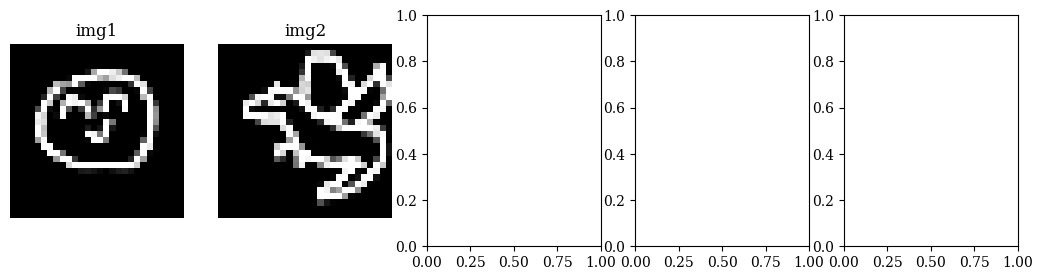

1/1 [==============================] - 0s 33ms/step
img1:  [('smiley face 笑脸', 61.37), ('face 脸', 35.48), ('potato 土豆', 2.76), ('pond 池塘', 0.35), ('watermelon 西瓜', 0.03)]
img1:  [('bird 鸟', 49.45), ('dragon 龙', 46.34), ('duck 鸭子', 1.27), ('rain 雨', 0.76), ('angel 天使', 0.72)]


In [10]:
X = []
resize = layers.Resizing(28, 28)
print(PATH_CUSTOMS)
N = len(list(PATH_CUSTOMS.iterdir()))
print(N)
row = (N+4)//5
fig, axs = plt.subplots(row,5,figsize=(13,3*row))
if N <= 5: axs = axs.reshape(1,-1)
for idx, f in enumerate(PATH_CUSTOMS.iterdir()):
    img = np.array(Image.open(f).convert('L'))
    img = np.expand_dims(img, axis=-1)
    img = 1. - resize(img) / 255.
    X.append(img)
    plot_img(axs[idx//5, idx%5], img, title=f"img{idx+1}")
plt.show()
X = np.array(X)

pred = model.predict(X)
pred_summary = []
for i in range(N):
    top5_idxs = np.argsort(pred[i])[::-1][:5]
    top5_labels = target_labels[top5_idxs]
    top5_summary = [(x+' '+eng_to_chn[x], np.round(pred*100,2)) for x, pred in zip(top5_labels, pred[i][top5_idxs])]
    print("img1: ", top5_summary)
    pred_summary.append(top5_summary)
# pred_idx = np.argmax(pred, axis=-1)
# pred_label = [x+' '+eng_to_chn[x] for x in target_labels[pred_idx]]
# print("预测结果", pred_label)

In [7]:
i = 5
top5_idx = np.argsort(pred[i])[::-1][:5]
print(np.round(pred[i][top5_idx], 3))
target_labels[np.argsort(pred[i])[::-1][:5]]

IndexError: index 5 is out of bounds for axis 0 with size 1

In [ ]:
print(np.round(pred[i][np.argsort(pred[i])[::-1][:10]], 3))